In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 3060 || GPU || 2.0 GiB
 /device:GPU:1 ||  NVIDIA GeForce RTX 3060 || GPU || 9.4 GiB


In [3]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
import keras.backend as K
import random
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import pandas as pd
import numpy as np
from keras.metrics import AUC, Precision, Recall, Accuracy
from sklearn.metrics import f1_score
from keras.callbacks import LambdaCallback
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU memory growth has been limited successfully!")
except:
    print("Failed to limit the GPU memory growth.")

GPU memory growth has been limited successfully!


In [5]:
GPUS = ["GPU:0", "GPU:1"]
strategy = tf.distribute.MirroredStrategy(GPUS,
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


# Importing dependencies

In [6]:
train_data_dir = r"C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/FER2013/FER2013 - names/train/"
validation_data_dir = r"C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/FER2013/FER2013 - names/test/"

In [7]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
num_classes = 7
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

IMAGE_SHAPE = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

batch_size=16*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)

class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [8]:
# Data augmentation
# Data augmentation

train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

valid_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory = validation_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


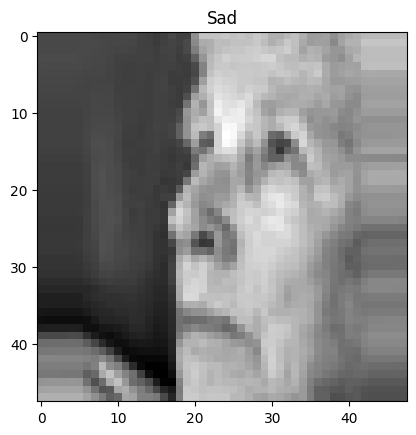

In [9]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [10]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,3995,436,4097,7215,4965,4830,3171
test,958,111,1024,1774,1233,1247,831


In [11]:
# Data labels

class_labels = valid_generator.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [12]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

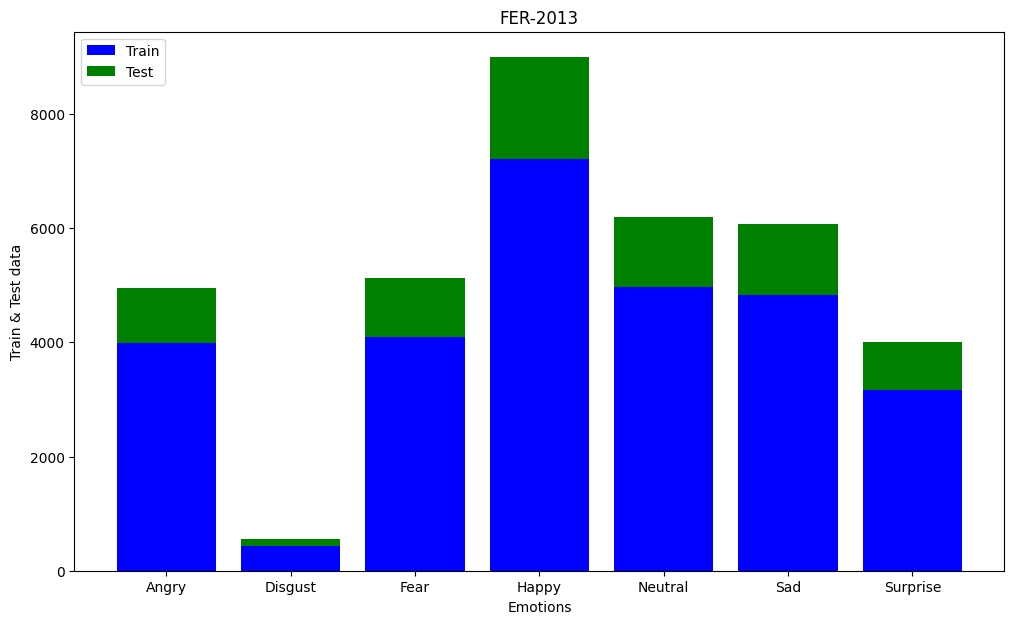

In [13]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='green')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

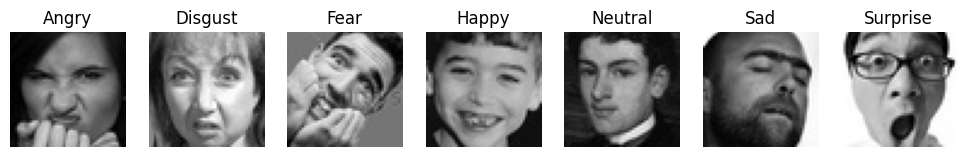

In [14]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()


In [ ]:
# class_weights = class_weight.compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(train_generator.classes),
#                                         y = train_generator.classes                                                    
#                                     )
# class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
# class_weights



In [ ]:
# from collections import Counter

# counter = Counter(train_generator.classes)                          
# max_val = float(max(counter.values()))       
# class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     
# print(class_weights)

In [15]:

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(7, activation='softmax'))

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [ ]:
with strategy.scope():


    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(7, activation='softmax'))


    counter = Counter(train_generator.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     

    filepath="checkpoints_freeze/toy-model_1-epoch-{epoch:02d}-val_accuracy-{val_accuracy:.2f}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='auto', period=1)


    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

    model.summary()

     # Train model
    history = model.fit(
            train_generator,
            steps_per_epoch = num_train_imgs//batch_size,
            epochs=50,
            validation_data=valid_generator,
            validation_steps = num_test_imgs//batch_size,
            class_weight=class_weights,
            callbacks=[checkpoint, csv_logger],
            verbose=1
    )

In [ ]:
save_model = model.save('Sequential_50e.h5')

# Model Evaluation

In [15]:
model = load_model('Sequential_50e.h5')

In [16]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(valid_generator)

225/225 [==============================] - 6s 28ms/step - loss: 1.0572 - accuracy: 0.6106


Best batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
1/1 [==============================] - 0s 86ms/step
Accuracy =  0.84375


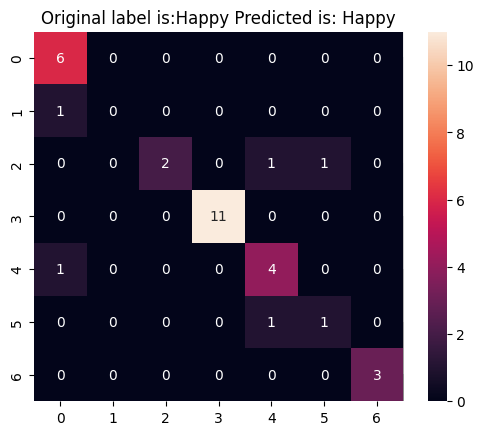

1/1 [==============================] - 0s 20ms/step
Accuracy =  0.375


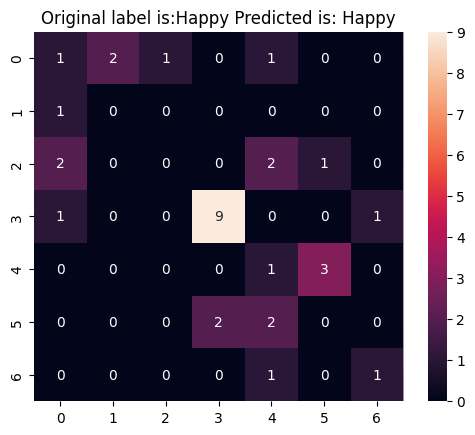

In [17]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(valid_generator.n // batch_size):
    test_img, test_lbl = valid_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [18]:
total_acc = 0
num_batches = valid_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = valid_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.6104


In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(valid_generator.n // batch_size):
    test_img, test_lbl = valid_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = valid_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{valid_generator.n} acc: {class_acc:.1f}")


1/1 [==============================] - 0s 20ms/step
Accuracy: 61.03515625
Angry 956/7178 acc: 57.8
Disgust 111/7178 acc: 47.7
Fear 1024/7178 acc: 23.3
Happy 1768/7178 acc: 80.3
Neutral 1232/7178 acc: 57.8
Sad 1247/7178 acc: 56.0
Surprise 830/7178 acc: 84.3


In [20]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = valid_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{valid_generator.n} acc: {class_acc:.1f}")


Accuracy: 61.03515625
Angry 956/7178 acc: 57.8
Disgust 111/7178 acc: 47.7
Fear 1024/7178 acc: 23.3
Happy 1768/7178 acc: 80.3
Neutral 1232/7178 acc: 57.8
Sad 1247/7178 acc: 56.0
Surprise 830/7178 acc: 84.3


In [ ]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Get the true labels and predictions for all the validation data
# y_true = []
# y_pred = []

# for i in range(valid_generator.n // batch_size):
#     test_img, test_lbl = valid_generator.__getitem__(i)
#     pred_lbl = model.predict(test_img)
#     y_true.extend(np.argmax(test_lbl, axis=1))
#     y_pred.extend(np.argmax(pred_lbl, axis=1))

# # Calculate the overall accuracy
# accuracy = accuracy_score(y_true, y_pred) * 100
# print(f"Accuracy: {accuracy}")

# # Calculate the accuracy for each class
# class_names = valid_generator.class_indices.keys()
# class_accuracy = {}

# for i, class_name in enumerate(class_names):
#     class_idx = i
#     class_mask = [True if label == class_idx else False for label in y_true]
#     class_true = np.array(y_true)[class_mask]
#     class_pred = np.array(y_pred)[class_mask]
#     class_acc = accuracy_score(class_true, class_pred) * 100
#     class_accuracy[class_name] = class_acc
#     print(f"{class_name} {len(class_true)}/{valid_generator.n} acc: {class_acc:.1f}")

# # Generate the confusion matrix
# confusion_mtx = confusion_matrix(y_true, y_pred)

# # Print the classification report
# print(classification_report(y_true, y_pred, target_names=class_names))

# # Plot the confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,8))
# sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

              precision    recall  f1-score   support

       Angry       0.49      0.58      0.53       956
     Disgust       0.57      0.48      0.52       111
        Fear       0.57      0.23      0.33      1024
       Happy       0.85      0.80      0.83      1768
     Neutral       0.57      0.58      0.57      1232
         Sad       0.46      0.56      0.50      1247
    Surprise       0.65      0.84      0.73       830

    accuracy                           0.61      7168
   macro avg       0.59      0.58      0.57      7168
weighted avg       0.62      0.61      0.60      7168



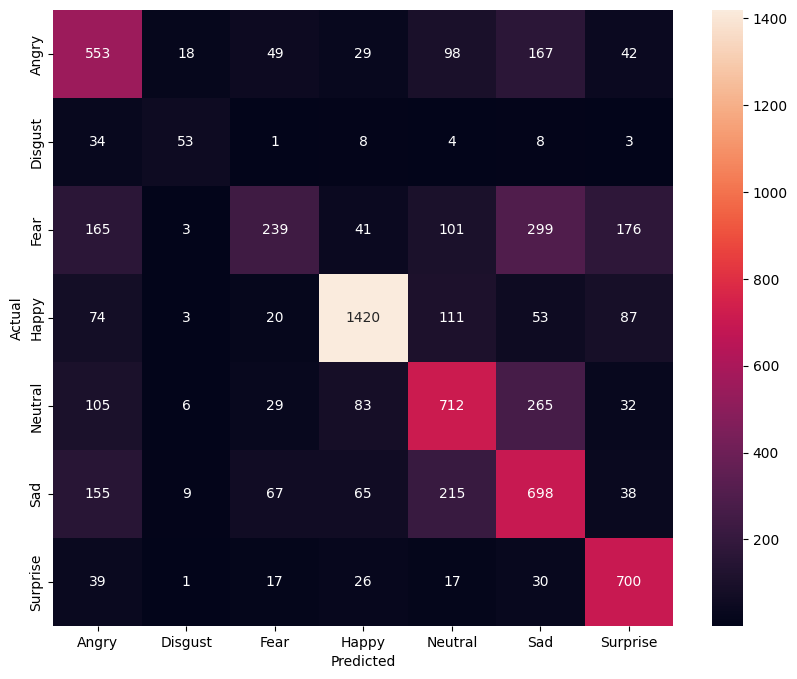

In [21]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# #Generate a batch of images
# test_img, test_lbl = valid_generator.__next__()
# predictions=model.predict(test_img)

# predictions = np.argmax(predictions, axis=1)
# test_labels = np.argmax(test_lbl, axis=1)

# from sklearn import metrics
# print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

# #Confusion Matrix - verify accuracy of each class
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, predictions)
# #print(cm)
# import seaborn as sns
# sns.heatmap(cm, annot=True)

# class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# #Check results on a few select images
# n=random.randint(0, test_img.shape[0] - 1)
# image = test_img[n]
# orig_labl = class_labels[test_labels[n]]
# pred_labl = class_labels[predictions[n]]
# plt.imshow(image[:,:,0], cmap='gray')
# plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
# plt.show()

In [ ]:
# from collections import defaultdict

# # Initialize a dictionary to keep track of correct and incorrect predictions for each class
# class_stats = defaultdict(lambda: {'correct': 0, 'incorrect': 0})

# test_img, test_lbl = valid_generator.__next__()
# predictions=model.predict(test_img)

# predictions = np.argmax(predictions, axis=1)
# test_labels = np.argmax(test_lbl, axis=1)

# for i in range(len(predictions)):
#     class_name = class_labels[test_labels[i]]
#     if predictions[i] == test_labels[i]:
#         class_stats[class_name]['correct'] += 1
#     else:
#         class_stats[class_name]['incorrect'] += 1

# total_correct = sum([stats['correct'] for stats in class_stats.values()])
# total_incorrect = sum([stats['incorrect'] for stats in class_stats.values()])
# total_predictions = total_correct + total_incorrect
# accuracy_percentage = 100 * total_correct / total_predictions

# for class_name, stats in class_stats.items():
#     print(f"Class {class_name}:")
#     print(f"  Correct predictions: {stats['correct']}")
#     print(f"  Incorrect predictions: {stats['incorrect']}")

# print(f"/nTotal number of correct predictions: {total_correct}")
# print(f"Total number of incorrect predictions: {total_incorrect}")
# print(f"Percentage of correct predictions: {accuracy_percentage:.2f}%")

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# test unseen batch

In [6]:
model = load_model('Sequential_50e.h5')

In [22]:
test_data_dir = r'C:\Users\darks\Desktop\Emotion AI\Emotion Recognition\DATASETS\Batch_Ready 7'

In [23]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
num_classes = 7
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

IMAGE_SHAPE = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

batch_size=16*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)

class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


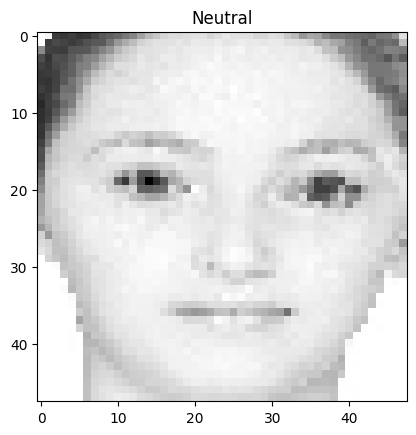

In [25]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

# Best and Worst Batch Accuracy

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
1/1 [==============================] - 0s 17ms/step
Accuracy =  0.71875


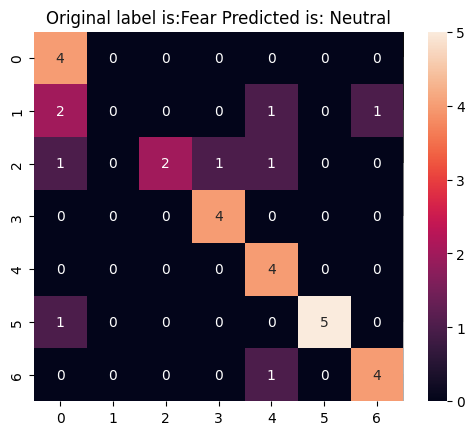

1/1 [==============================] - 0s 19ms/step
Accuracy =  0.3125


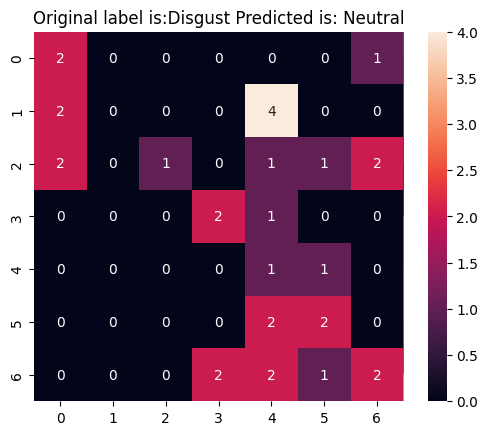

In [26]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Average Accuracy

In [27]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.5125


In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


1/1 [==============================] - 0s 17ms/step
Accuracy: 51.24999999999999
Angry 297/2100 acc: 76.4
Disgust 296/2100 acc: 10.1
Fear 298/2100 acc: 17.8
Happy 297/2100 acc: 83.5
Neutral 297/2100 acc: 79.5
Sad 299/2100 acc: 34.8
Surprise 296/2100 acc: 56.8


In [29]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 51.24999999999999
Angry 297/2100 acc: 76.4
Disgust 296/2100 acc: 10.1
Fear 298/2100 acc: 17.8
Happy 297/2100 acc: 83.5
Neutral 297/2100 acc: 79.5
Sad 299/2100 acc: 34.8
Surprise 296/2100 acc: 56.8


              precision    recall  f1-score   support

       Angry       0.46      0.76      0.57       297
     Disgust       0.94      0.10      0.18       296
        Fear       0.63      0.18      0.28       298
       Happy       0.65      0.84      0.73       297
     Neutral       0.41      0.79      0.54       297
         Sad       0.45      0.35      0.39       299
    Surprise       0.59      0.57      0.58       296

    accuracy                           0.51      2080
   macro avg       0.59      0.51      0.47      2080
weighted avg       0.59      0.51      0.47      2080



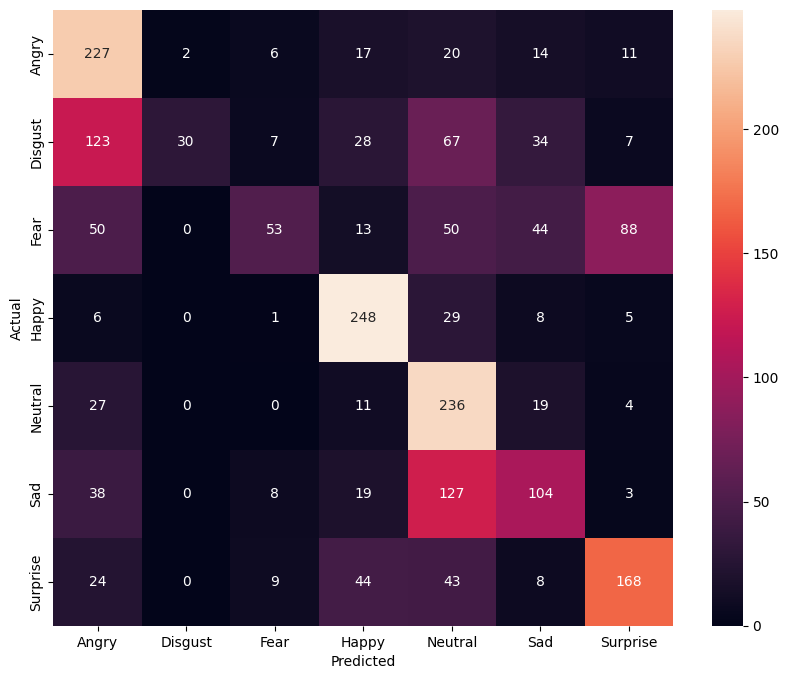

In [30]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()